In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import kagglehub


2025-05-07 22:02:27.983339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746644548.009319   31818 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746644548.018822   31818 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746644548.051394   31818 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746644548.051441   31818 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746644548.051444   31818 computation_placer.cc:177] computation placer alr

In [24]:
from tensorflow.keras import layers

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


I0000 00:00:1746644570.103465   31818 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [27]:

path = kagglehub.dataset_download("vinayjayanti/skin-lesion-image-classification")

print("Path to dataset files:", path)

path += "/my_data"
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")
validation_path = os.path.join(path, "val")

Path to dataset files: /home/bogdan/.cache/kagglehub/datasets/vinayjayanti/skin-lesion-image-classification/versions/1


Found 10940 files belonging to 14 classes.


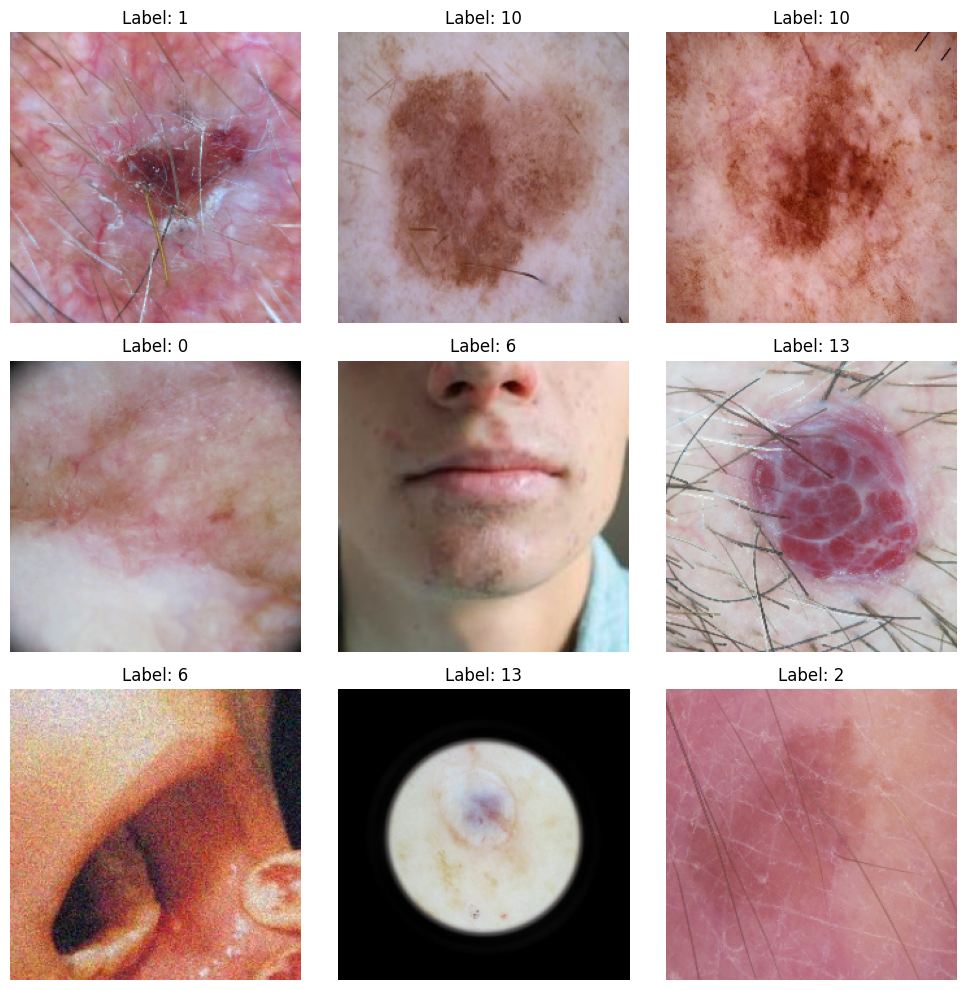

2025-05-07 22:59:09.650863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=9,  # small batch for display
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

# Take one batch
for images, labels in raw_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),            # Random horizontal flip
    layers.RandomRotation(0.1),                 # Random rotation by 10%
    layers.RandomZoom(0.1),                     # Random zoom in/out
    layers.RandomTranslation(0.1, 0.1),         # Random shift (10% height/width)
    layers.RandomContrast(0.1),                 # Random contrast adjustment
])

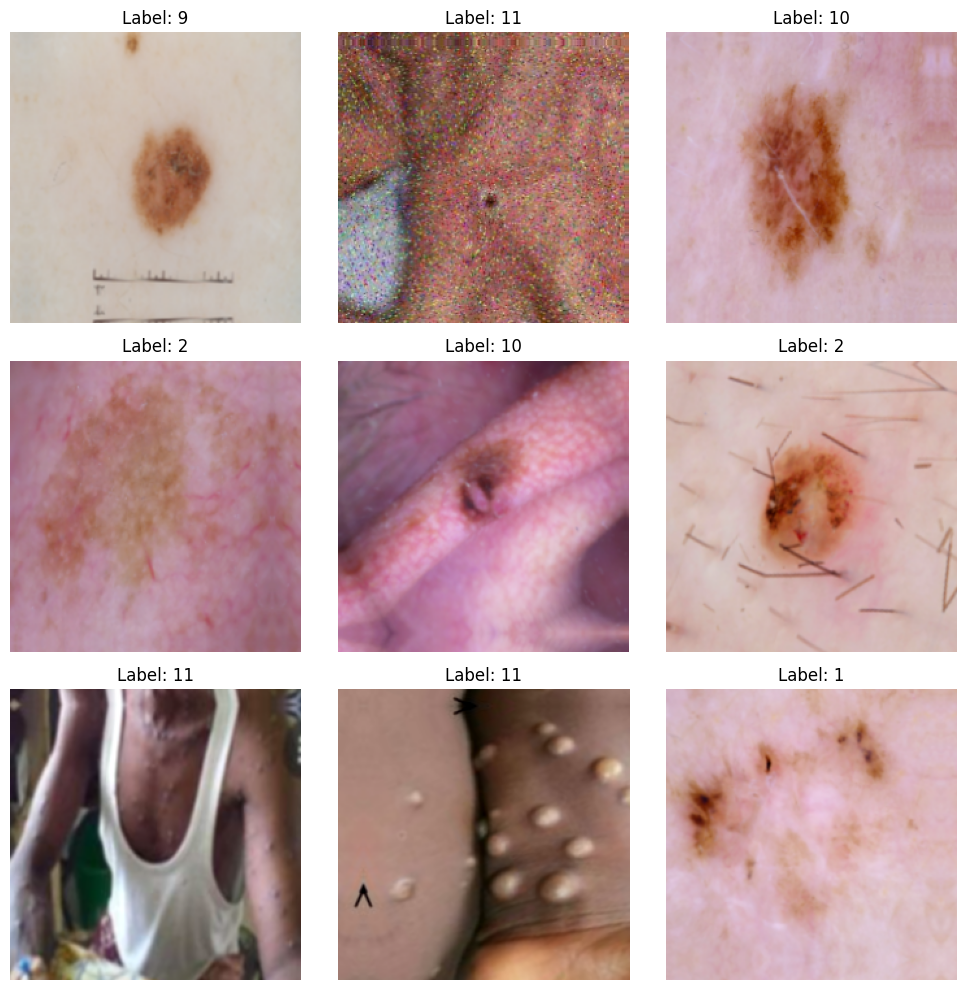

2025-05-07 22:59:49.165740: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
for images, labels in raw_train_ds.take(1):
    augmented_images = data_augmentation(images, training=True)  # Apply augmentation

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [39]:


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42,
    color_mode='rgb',
    class_names=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
).map(lambda x, y: (data_augmentation(x, training=True), y),
     num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False,
    seed=42,
    color_mode='rgb',
    class_names=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
).prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False,
    seed=42,
    color_mode='rgb',
    class_names=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
).prefetch(buffer_size=AUTOTUNE)


Found 10940 files belonging to 14 classes.
Found 1177 files belonging to 14 classes.
Found 1185 files belonging to 14 classes.


In [40]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))
])
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2) ))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2) ))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2) ))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=14, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     6,291,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,454,286 (24.62 MB)

 Trainable params: 6,453,710 (24.62 MB)

 Non-trainable params: 576 (2.25 KB)

In [42]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=32,
    epochs=40,
    # callbacks=[early_stop, reduce_lr]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)

Epoch 1/40


2025-05-07 23:09:54.373046: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %bitcast.11951, f32[32,3,3,3]{3,2,1,0} %bitcast.11958, f32[32]{0} %bitcast.13239), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_6_1/conv2d_8_1/convolution" source_file="/home/bogdan/www/Skanderm/model_training/venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 23:09:54.457175: I external/local_xla/xla/service/gpu/autotuning/conv_algo

341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.1538 - loss: 4.9912

2025-05-07 23:11:49.265393: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[28,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,256,256]{3,2,1,0} %bitcast.11951, f32[32,3,3,3]{3,2,1,0} %bitcast.11958, f32[32]{0} %bitcast.13239), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_6_1/conv2d_8_1/convolution" source_file="/home/bogdan/www/Skanderm/model_training/venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 23:11:49.340199: I external/local_xla/xla/service/gpu/autotuning/conv_algo

342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.1538 - loss: 4.9860

2025-05-07 23:11:59.605250: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %bitcast.729, f32[32,3,3,3]{3,2,1,0} %bitcast.736, f32[32]{0} %bitcast.738), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_6_1/conv2d_8_1/convolution" source_file="/home/bogdan/www/Skanderm/model_training/venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 23:11:59.681590: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_

342/342 ━━━━━━━━━━━━━━━━━━━━ 135s 349ms/step - accuracy: 0.1539 - loss: 4.9809 - val_accuracy: 0.1810 - val_loss: 2.8027
Epoch 2/40
  1/342 ━━━━━━━━━━━━━━━━━━━━ 5:31 973ms/step - accuracy: 0.2500 - loss: 2.1283

2025-05-07 23:12:05.575082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


256/342 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.2207 - loss: 2.1001

: 